# Final Project Sketch :(


In [8]:
import pandas as pd
import numpy as np
import os
from math import sin, cos, sqrt, atan2, radians
import time
import matplotlib.pyplot as plt
import datetime


%matplotlib inline

pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="E:/GitHub/NYU-Taxi-project/My First Project-b3735f3b3a9d.json"
from google.cloud import bigquery
client = bigquery.Client()

## Query Data from BigQuery

In [14]:
start = time.time()
query = (
"""
SELECT date_of_year, month_of_year, day_of_year, pickup_hour,
    dropoff_datetime,pickup_datetime,
    pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude, travel_time,
    temp, visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
FROM
(
      SELECT *,ROW_NUMBER() OVER(partition by date_of_year, pickup_hour) as row_number
      FROM
      (
            SELECT pickup_datetime, dropoff_datetime, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude,
            EXTRACT (HOUR FROM pickup_datetime) as pickup_hour,
            EXTRACT (DAY FROM pickup_datetime) as day_of_year,
            EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
            EXTRACT (DATE FROM pickup_datetime) as date_of_year,
            TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) as travel_time
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and
                dropoff_longitude IS NOT NULL and dropoff_latitude IS NOT NULL
      ) x
) x
JOIN
(
 select cast(mo as int64) as month,cast(da as int64) as day,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
 from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
) y on x.month_of_year = y.month and x.day_of_year = y.day
where x.row_number <= 200
"""
)
data=pd.io.gbq.read_gbq(query,dialect='standard')
end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Time taken by above cell is 4.766623584429423.


In [84]:
data.head()

,date_of_year,month_of_year,day_of_year,pickup_hour,dropoff_datetime,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,travel_time,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,2016-01-24,1,24,14,2016-01-24 15:00:00,2016-01-24 14:09:49,-73.981178,40.763863,-73.782532,40.644104,3011,26.7,7.4,17.1,6.3,26.0,35.1,19.9,1.82,5.9,1,0,1,0,0
1,2016-01-24,1,24,14,2016-01-24 14:46:18,2016-01-24 14:23:51,-74.001999,40.728172,-73.988266,40.759232,1347,26.7,7.4,17.1,6.3,26.0,35.1,19.9,1.82,5.9,1,0,1,0,0
2,2016-01-24,1,24,14,2016-01-24 14:05:28,2016-01-24 14:00:46,-73.977997,40.742031,-73.975990,40.751331,282,26.7,7.4,17.1,6.3,26.0,35.1,19.9,1.82,5.9,1,0,1,0,0
3,2016-01-24,1,24,14,2016-01-24 14:18:33,2016-01-24 14:06:42,-73.981468,40.778969,-73.959068,40.809368,711,26.7,7.4,17.1,6.3,26.0,35.1,19.9,1.82,5.9,1,0,1,0,0
4,2016-01-24,1,24,14,2016-01-24 14:18:29,2016-01-24 14:10:10,-74.016273,40.710487,-74.006577,40.732365,499,26.7,7.4,17.1,6.3,26.0,35.1,19.9,1.82,5.9,1,0,1,0,0


## Summary of Data

In [3]:
# Return high level information about data
data.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435709 entries, 0 to 38318
Data columns (total 25 columns):
date_of_year         435709 non-null datetime64[ns]
month_of_year        435709 non-null int64
day_of_year          435709 non-null int64
pickup_hour          435709 non-null int64
dropoff_datetime     435709 non-null datetime64[ns]
pickup_datetime      435709 non-null datetime64[ns]
pickup_longitude     435709 non-null float64
pickup_latitude      435709 non-null float64
dropoff_longitude    435709 non-null float64
dropoff_latitude     435709 non-null float64
travel_time          435709 non-null int64
temp                 435709 non-null float64
visib                435709 non-null float64
mxpsd                435709 non-null object
wdsp                 435709 non-null object
gust                 435709 non-null float64
max                  435709 non-null float64
min                  435709 non-null float64
prcp                 435709 non-null float64
sndp                 435

## Create/Transform features

In [24]:
data["weekday"] = data['pickup_datetime'].dt.dayofweek

data['travel_time'] = round(data['travel_time']/60, 2)

## Process Missing Data & Outlier

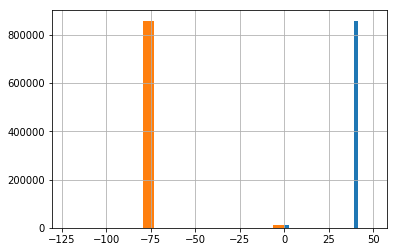

In [16]:
data['pickup_latitude'].hist(bins=20)
data['pickup_longitude'].hist(bins=20)

data = data[(data['pickup_longitude'] >= -79.7624) & (data['pickup_longitude'] <= -71.7517) &
                    (data['pickup_latitude'] >= 40.4772) & (data['pickup_latitude'] <= 45.0153)]

data = data[(data['dropoff_longitude'] >= -79.7624) & (data['dropoff_longitude'] <= -71.7517) &
                    (data['dropoff_latitude'] >= 40.4772) & (data['dropoff_latitude'] <= 45.0153)]

In [17]:
R = 6373.0

dlon = np.radians(data['dropoff_longitude']) - np.radians(data['pickup_longitude'])
dlat = np.radians(data['dropoff_latitude']) - np.radians(data['pickup_latitude'])

a = np.sin(dlat / 2)**2 + np.cos(data['pickup_latitude']) * np.cos(data['dropoff_latitude']) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

data['distance_in_km'] = R*c

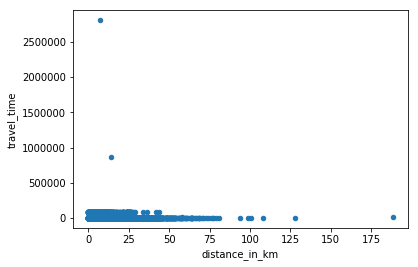

In [18]:
data.plot(x='distance_in_km',y='travel_time',kind='scatter')

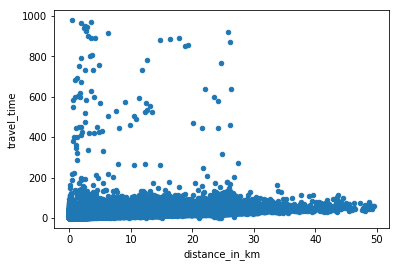

In [27]:
data_sm = data[(data['travel_time']>0) & (data['distance_in_km']<50)  & (data['travel_time']<1000)]

data_sm.plot(x='distance_in_km',y='travel_time',kind='scatter')

## Optimize the memory usage

In [11]:
# # Create a function to be calculating memory usage
# def get_usage(obj):
#     if isinstance(obj, pd.DataFrame):
#         usage = obj.memory_usage(deep=True).sum()
#     else:
#         usage = obj.memory_usage(deep=True)
#     return "{:03.2f} MB".format(usage / (1024**2))

# # Convert int64 to int8
# obj = data.select_dtypes(include = 'int64')
# obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

# # Convert float64 to float32
# obj = data.select_dtypes(include = 'float64')
# obj_f = obj.apply(pd.to_numeric, downcast='float')

# # Calculated the memory we reduced by down grade int and float
# data_opt = data.copy()
# data_opt[obj_int.columns] = obj_int
# data_opt[obj_f.columns] = obj_f
# print("Original memory usage: ", get_usage(data))
# print("After converting int and float memory usage: ", get_usage(data_opt))

Original memory usage:  440.32 MB
After converting int and float memory usage:  383.01 MB


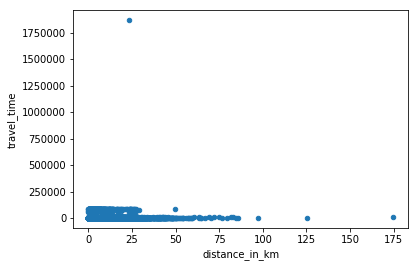

In [10]:
#data = data[(data['distance_in_km'] > 0.1)]
data.plot(x='distance_in_km',y='travel_time',kind='scatter')

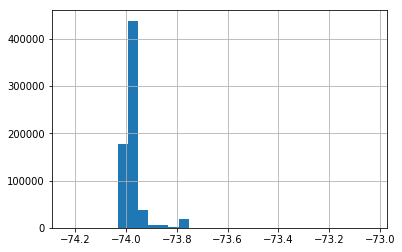

In [35]:
data_opt['pickup_longitude'].hist(bins=30)

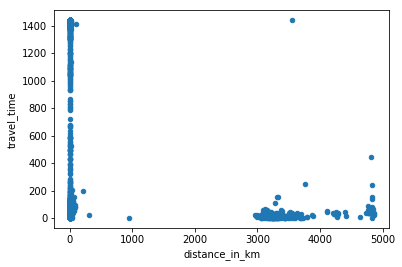

In [36]:
data_opt = data_opt[(data_opt['travel_time']>0) & (data_opt['distance_in_km']<5000)  & (data_opt['travel_time']<20000)]
data_opt.plot(x='distance_in_km',y='travel_time',kind='scatter')

In [16]:
data_opt.head(5)

,date_of_year,month_of_year,day_of_year,pickup_hour,dropoff_datetime,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,travel_time,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,distance_in_km
0,2016-01-01,1,1,11,2016-01-01 11:10:51,2016-01-01 11:03:50,-73.968033,40.759506,-73.986877,40.735752,7,40.400002,10.0,6.5,22.9,48.0,37.0,0.03,999.900024,0,0,0,0,0,2.523361
1,2016-01-01,1,1,11,2016-01-01 12:10:58,2016-01-01 11:57:46,-73.997055,40.722179,-73.977394,40.758743,13,40.400002,10.0,6.5,22.9,48.0,37.0,0.03,999.900024,0,0,0,0,0,3.967209
2,2016-01-01,1,1,11,2016-01-01 11:35:34,2016-01-01 11:26:49,-73.983940,40.775303,-73.975273,40.759426,8,40.400002,10.0,6.5,22.9,48.0,37.0,0.03,999.900024,0,0,0,0,0,1.724558
4,2016-01-01,1,1,11,2016-01-01 11:33:30,2016-01-01 11:31:48,-73.967598,40.755981,-73.976486,40.743851,1,40.400002,10.0,6.5,22.9,48.0,37.0,0.03,999.900024,0,0,0,0,0,1.297900
6,2016-01-01,1,1,11,2016-01-01 12:26:39,2016-01-01 11:57:15,-73.781906,40.644878,-73.956482,40.763008,29,40.400002,10.0,6.5,22.9,48.0,37.0,0.03,999.900024,0,0,0,0,0,13.765106


In [17]:
data.head(5)

,date_of_year,month_of_year,day_of_year,pickup_hour,dropoff_datetime,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,travel_time,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,distance_in_km
0,2016-01-01,1,1,11,2016-01-01 11:10:51,2016-01-01 11:03:50,-73.968033,40.759506,-73.986877,40.735752,7,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,2.523361
1,2016-01-01,1,1,11,2016-01-01 12:10:58,2016-01-01 11:57:46,-73.997055,40.722179,-73.977394,40.758743,13,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,3.967209
2,2016-01-01,1,1,11,2016-01-01 11:35:34,2016-01-01 11:26:49,-73.983940,40.775303,-73.975273,40.759426,8,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,1.724558
3,2016-01-01,1,1,11,2016-01-01 11:33:35,2016-01-01 11:30:19,0.000000,0.000000,0.000000,0.000000,3,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,0.000000
4,2016-01-01,1,1,11,2016-01-01 11:33:30,2016-01-01 11:31:48,-73.967598,40.755981,-73.976486,40.743851,1,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,1.297900


## EDA

In [67]:
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train_df['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

NameError: name 'time' is not defined

In [54]:
sum(np.isnan(data['distance_in_km'] ))

159312

In [80]:
system.time()

NameError: name 'system' is not defined

In [79]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='zxf71699', api_key='BkltlyEFcOkOAgCSdkjt')